# <center>Entrenar y evaluar una red neuronal convolucional para resolver un problema de clasificación de imágenes</center>

<div style="background-color: #fdebd0 ">
<b>Este TP tiene 3 objetivos:</b><br>
- Describir conceptos vinculados al entrenamiento y uso de <i>ConvNets</i> para la clasificación de imágenes<br>
- Familiarizarse con la librería PyTorch<br>
- Reproducir un protocolo para entrenar una red neuronal convolucional y clasificar imágenes.</div>


PyTorch es una librería de aprendizaje automático de código abierto para Python, desarrollada principalmente por el grupo de investigación de inteligencia artificial de Facebook. Dentro de PyTorch, el paquete <code>torchvision</code> consiste en conjuntos de datos populares, arquitecturas de modelos y transformaciones de imágenes comunes para la visión artificial.

En la primera parte del trabajo práctico, utilizaremos el conjunto de datos CIFAR10 disponible en <code>torchvision</code>.  Este dataset sirve para aprender a resolver un problema de clasificación con 10 clases: 'avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión'. Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir, imágenes en color de 3 canales de 32x32 píxeles de tamaño: https://www.cs.toronto.edu/~kriz/cifar.html

El código está basado en el tutorial de PyTorch siguiente: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

<img src="cifar10.png"></img>

Para resolver el problema de clasificación de imágenes, seguiremos los siguientes pasos:

- Cargar y normalizar los conjuntos de datos de entrenamiento y pruebas utilizando CIFAR10.
- Configurar una red neuronal de convolución
- Definir una función de pérdida
- Optimizar la red sobre los datos de entrenamiento
- Probar el rendimiento de la red con los datos de test

Por cada paso, se solicita responder a una serie de preguntas.

## 1. Cargar y normalizar el dataset CIFAR10

In [1]:
#el paquete torch contiene estructuras de datos para tensores multidimensionales y se definen operaciones
#matemáticas sobre estos. Además, proporciona muchas utilidades para la serialización eficiente de tensores y tipos
#arbitrarios, y otras utilidades útiles.
import torch
#torchvision: libreria de imagenes
import torchvision
#TRANSFORMACIONES DE IMAGENES COMUNES
import torchvision.transforms as transforms

#La salida del conjunto de datos "torchvision" son imagenes del tipo PILImage de rango [0, 1]. 


#Compose: Compone varias transformaciones juntas. 
# Define una función que realizará varias transformaciones de forma simultanea
#ToTensor(): Convierte una imagen PIL o un numpy.ndarray a un tensor.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset: (image, target) donde target es un indice de la clase de target.
# root:      Directorio en mi computadora del servidor Anaconda donde el data set será guardado si no existe.
# train:     Si es Verdadero, crea un conjunto de datos desde el conjunto de entrenamiento, de lo contrario crea desde el conjunto de prueba.
# download:  Si es verdadero, descarga el conjunto de datos de Internet y lo coloca en el directorio raíz. 
#            Si el conjunto de datos ya está descargado, no se vuelve a descargar.
# transform: Una función / transformación que toma una imagen PIL y devuelve una versión transformada.

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#### Data loader: Combina un conjunto de datos y una muestra, y proporciona iteradores de proceso único o 
#                    múltiple sobre el conjunto de datos. 

# trainset: Conjunto de datos desde donde se cargaran los datos.
# batch_size: Cuántas muestras por lote cargar. 
# shuffle: Configúrelo en Verdadero para que los datos se reorganicen en cada época.
# num_workers: How many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
<b>1) ¿Cuál es el tamaño del dataset de entrenamiento y del dataset de test? (Imprimir el resultado con la función <code>print</code>)</b><br>
Como se observa abajo, el tamaño del dataset de entrenamiento es de 50000 datos y el tamaño del dataset de test es de 10000 datos.

In [2]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


In [3]:
print(testset)

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None


<div style="background-color: #fdebd0 ">
<b>2) ¿Por qué el parametro <code>shuffle</code> se configura "True" para el dataset de entrenamiento y "False" para el dataset de test? </b><br>
    
Este parametro se configura True para que el sub conjunto de datos que será tomado del dataset sea "barajado", es decir el orden de las imagenes sea cambiado de forma aleatoria. Y se configura false para que el sub conjunto de datos que será tomado del dataset NO sea "barajado".<br> 
<b>¿De qué sirve este parametro?</b><br>
Sirve para que al entrenar el modelo el orden en el que se encuentran las imagenes no introdusca algún sesgo al modelo.
    
   

<B>El código siguiente permite mostrar imagenes aleatorias del dataset de entrenamiento y su etiqueta real:

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imagesFromBatches(iterator,quantity):
    dataiter = iter(iterator)
    images, labels = dataiter.next()    
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(quantity)))
    return (images,labels)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 640x480 with 1 Axes>

  cat  ship   dog   car


## 2. Configurar la CNN

In [5]:
import torch.nn as nn
# Importa funciones de convolución
import torch.nn.functional as F

from torchsummary import summary

# nn.Module: Clase base para todos los módulos de red neuronal. Sus modelos también deben subclasificar esta clase.
#### ESTA CREANDO UN OBJETO QUE SERA LA RED NEURONAL
class Net(nn.Module):
    #### Módulo de red neuronal?? - ¿ESTA CREANDO EL CONSTRUCTOR DEL OBJETO
    def __init__(self):
        super(Net, self).__init__()
        #### ESTAS SON FUNCIONES PRIVADAS DEL OBJETO
        
        # CONVOLUCION: Transformar la imagen para representar sus características relevantes y eliminar la información irrelevante
        # para resolver el problema de clasificación.
        
        # nn.Conv2d(in_channels, out_channels, kernel_size): Aplica una convolución 2D sobre una señal de entrada
        #                                                    compuesta de varios planos de entrada.
        #    in_channels: Número de canales en la imagen de entrada.
        #    out_channels: Número de canales producidos por la convolución. Número de filtros.
        ####    kernel_size: Tamaño del núcleo que está convolucionando. -- TAMAÑO DEL FILTRO EN ESTA CASO MATRIZ 5X5
        self.conv1 = nn.Conv2d(3, 6, 5)
        
        # POOLING: Reducir el tamaño de las imágenes, acelerar los tiempos de cálculo y mejorar la detección de las características
        # nn.MaxPool2d(kernel_size, stride=None): Aplica un max pooling 2D sobre una señal de entrada compuesta por varios planos de entrada.
        #            kernel_size: El tamaño de la ventana sobre la cual se tomara un máximo. El tamaño del filtro.
        #            stride: El paso de la ventana.
        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #Fully-connected layers o MultiLayer Perceptron - Ultimas capas de la CNN o red neuronal convolucional
        # Algoritmo Perceptrón (Rosemblatt, 1962) resuelve problema de clasificación binaria.
        # nn.Linear(in_features, out_features): Aplica una transformación lineal a los datos entrantes: y = xA^T+b
        #         in_features: Tamaño de cada muestra de entrada.: metodos de clasficiacion
        #         out_features: Tamaño de cada muestra de salida.
        #         
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
<B>1) ¿Cuántas capas tiene esta ConvNet?</B><br>
    7 capas <br>
<B>2) Explicar los parametros de cada capa.</B>  <br>
nn.Conv2d(in_channels, out_channels, kernel_size):
<BR>
- in_channels: Número de canales en la imagen de entrada.
<BR>
- out_channels: Número de filtros<BR>
- kernel_size: Tamaño de los filtros. Por ejemplo: si es 5, el tamaño de los filtros será de 5x5. 
<br>
nn.MaxPool2d(kernel_size, stride=None):<br>
kernel_size: El tamaño de la ventana sobre la cual se tomara un máximo. El tamaño del filtro.<br>
stride: El paso del filtro.<br>
nn.Linear(in_features, out_features):<br> 
in_features: Cantidad de entradas que tendrá cada uno de los métodos de clasificación de esta capa.
    <br> 
out_features: Cantidad de métodos de clasificación de esta capa.<br>
    
<B>¿Cuántos filtros se utilizan en las capas de convolución?</B><BR>
Son en total 24 filtros. En la primera capa de convolución se utilizan 6 filtros. En la primera capa de pooling se utiliza 1 filtro.
En la segunda capa de convolución se utilizan 16 filtros y en la segunda capa de pooling de utiliza 1 filtro.<br>

<B>¿Cuál es el tamaño de los filtros?  </B>      
<br>
Todos los filtros en las capas de convolución son matrices de 5x5. Los filtros en las capas de pooling son de 2x2.   

<B>3) ¿Cuál es la diferencia entre la función <code>init</code> y <code>forward</code>?</B><br>
La función <code>init</code> es el constructor de la clase Net, inicializando sus funciones, mientras que la
función <code>forward</code> es una funcion que utiliza las funciones definidas en <code>init</code> para realizar el proceso de clasificación de imágenes, aplicando capas tras capa de la red neuronal a las imagenes de entrada. En resumen, define todo el proceso que tiene que seguir la imagen para pasar por la red neuronal.<br>
 
<B>4) ¿De qué sirve la función view()? Explicar sus parametros.</B><br>
    En este caso transforma un tensor multidimensional a un tensor de 1 dimensión. El primer parámetro de entrada de la función "view" define el nuevo número de
    filas que tendrá el tensor. El segundo parámetro define el nuevo número de columnas que tendrá el tensor. Si no se está seguro de la cantidad de filas que se quiere en el nuevo tensor, pero si se sabe la cantidad de columnas que se desea, entonces se puede colocar en el primer parámetro un "-1" y en el segundo parámetro se puede colocal el número de columnas deseado y de forma automática se esablecerá el número de filas dependiendo del número de columnas puesto.<BR>
<B>5) ¿Cuántos paramétros en total se tiene que aprender con esta ConvNet?</B> <br>
    62.006<br>
<B>6) ¿Por qué se utiliza la función <code>conv2d</code> aunque tenemos imagenes con 3 canales?</B><BR>
Porque el filtro tiene la misma dimesión que la imagen de entrada.
</div>

## 3. Entrenar la CNN

In [6]:
# torch.optim: Es un paquete que implementa varios algoritmos de optimización.
import torch.optim as optim

criterion = nn.CrossEntropyLoss()#calcula quien tiene el menor "gradiente", cual punto alrededor es el minimo

# optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False): Implementa stochastic gradient descent 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#algoritmo para actualizar los parametros

In [7]:
for epoch in range(4):  # loop over the dataset multiple times
#itera y trata de encontrar las lmejores solucions para este sistema
#hacer el proceso varias veces, empezando desde un punto distinto
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.141
[1,  4000] loss: 1.808
[1,  6000] loss: 1.658
[1,  8000] loss: 1.552
[1, 10000] loss: 1.493
[1, 12000] loss: 1.459
[2,  2000] loss: 1.387
[2,  4000] loss: 1.362
[2,  6000] loss: 1.320
[2,  8000] loss: 1.322
[2, 10000] loss: 1.290
[2, 12000] loss: 1.280
[3,  2000] loss: 1.204
[3,  4000] loss: 1.226
[3,  6000] loss: 1.192
[3,  8000] loss: 1.186
[3, 10000] loss: 1.199
[3, 12000] loss: 1.174
[4,  2000] loss: 1.110
[4,  4000] loss: 1.129
[4,  6000] loss: 1.094
[4,  8000] loss: 1.105
[4, 10000] loss: 1.116
[4, 12000] loss: 1.096
Finished Training


- Ver la video: https://www.youtube.com/watch?v=ErfnhcEV1O8 - A Short Introduction to Entropy, Cross-Entropy and KL-Divergence

- Leer: http://ruder.io/optimizing-gradient-descent/index.html - An overview of gradient descent optimization algorithm

<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
<b>1) ¿Qué hace la función <code>CrossEntropyLoss</code>? </b><br>
Nos dice cuan acertadas son las predicciones de nuestro modelo en comparación al conjunto de datos de entrenamiento.<BR>
<b>Qué devuelve?</b><br>
Un número que mienstras más se acerca a cero, significa que los resultados del modelo obtendio se parecen más a los resultados mostrados por los datos del dataset de entrenamiento.<br>
<b>¿Con qué otra función se podría reemplazar <code>CrossEntropy</code>?</b><br>
Multi class SVM Loss: Esta es una de las funciones de pérdida comunes utilizadas en Machine Learning.<br>
<b>2) ¿Cuál es la diferencia principal entre los métodos de optimización Gradient Descent, Stochastic Gradient Descent y Mini-Batch Gradient Descent?</b>
<br>
Pudiendo calcular el gradiente de la función de pérdida, se denomina Gradient Descent al proceso de evaluar repetidamente el gradiente y luego realizar una actualización de los parámetros del modelo, pero es lento y no puede tratar conjuntos de datos que no puedan ser cargados en su totalidad en la memoria ram.<br>

Una forma de explicar la diferencia entre estos métodos es decir que el método Gradient Descent es un igual a un modelo Mini-Batch con un mini-batch del tamaño del conjunto total de datos de entrenamiento. De la misma forma podriamos decir que un modelo Stochastic Gradient Descent es igual a un modelo Mini-Batch con un mini-batch de tamaño 1. Y finalemente el modelo Mini-Batch se espera sea un concenso entre SGD y GD con un mini.batch ni muy grande ni muy pequeño. En resumen la diferencia entre estos métodos es la cantidad de muestras que utilizan del dataset de entrenamiento para obtener los parámetros del modelo.<br>
 
<b>3) ¿En nuestro ejemplo, qué método utilizamos?</b><BR>
Mini-Batch Gradient Descent<BR>
<b>¿En qué parte del código se podría cambiar el tamaño del batch?</b><br> 
Cuando se define la función "trainloader".<br>
<b>4) ¿Qué metafora podemos utilizar para entender la idea del parametro <code>momentum</code>?</b><br>
Es como el efecto de la gravedad sobre una balón de futbol sobre una colina. A medida que va bajando la colina el balón comienza a acelerar. Así mismo a medida que el modelo va iterando y buscando su camino hacia un mínimo, si el modelo comeinza a "rebotar" de un lado a otro de modo que no avanza con mucha velocidad hacia el mínimo, el parámetro de momentum le permite dejar de "rebotar" y dirigirse más rápido hacia el mínimo.<br>
<b>5) ¿Podría ser útil aumentar el número de epoch? ¿Por qué? De qué sirve este parametro?</b><br>
Si, pues al ir cambiando de epoch se toma como punto inicial uno diferente al tomado anteriormente, lo que evita caer en la misma solución local todo el tiempo. Este parámetro sirve para definir el número de veces que pasaremos por todo nuestro dataset de entrenamiento entrenando nuestro modelo.<br>
</div>

## 4. Evaluar la CNN

Tomamos 4 ejemplos del dataset de test:

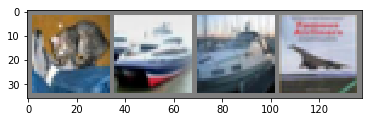

  cat  ship  ship plane


In [8]:
BatchSize=4

images,labels= imagesFromBatches(testloader,BatchSize)

Clasificamos estas 4 imágenes con nuestra CNN: 

In [9]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


<div style="background-color: #fdebd0 ">
<b>Pregunta</b><br>
<B>1) ¿Cuál es el rendimiento del modelo entrenado sobre estos primeros ejemplos?</B><BR>
EL RENDIMIENTO ES DE 100%, pues predijo todos los ejemplos de forma correcta.<br>
</div>

Calculamos el rendimiento de nuestra CNN sobre todos los datos del training set:

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 58 %


Miramos el rendimiento de la CNN calculando su exactitud según cada etiqueta:

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 78 %
Accuracy of  bird : 44 %
Accuracy of   cat : 35 %
Accuracy of  deer : 40 %
Accuracy of   dog : 41 %
Accuracy of  frog : 84 %
Accuracy of horse : 63 %
Accuracy of  ship : 79 %
Accuracy of truck : 55 %


<div style="background-color: #fdebd0 ">
<b>Preguntas:</b><br>
<b>1) ¿Qué paramétros podrían modificar para tratar de mejorar el rendimiento de la CNN?</b> <br>
Se podría modificar el tamaño del mini-batch y la tasa de aprendizaje.<BR>

<b>2) ¿Cómo se llama la arquitectura de CNN que hemos utilizado? (ver slides del curso y https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5 y https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)</b><br>
LeNet-5<br>
<b>3) ¿Qué pasa si tratan de agregar más filtros en la segunda capa de convolución?</b> <br>
Tendríamos que modificar la definición del input de la primera capa MLP. Además tendríamos que modificar también la definición de la función "view". A continuación se presenta un ejemplo en que se agregan 4 filtros más a la segunda capa de convolución:
    
<code>self.conv2 = nn.Conv2d(6, 16, 5)      ->        self.conv2 = nn.Conv2d(6, 20, 5)</code><br> 
<code>self.fc1 = nn.Linear(16 * 5 * 5, 120)       ->       self.fc1 = nn.Linear(20 * 5 * 5, 120) </code><br> 
<code>x = x.view(-1, 16 * 5 * 5)      ->       x = x.view(-1, 20 * 5 * 5) </code>  <br> 
<b>4) ¿Qué pasa si trata de agregar una tercera capa de convolución y pooling? </b><br>
Aparece un error de la función "view".
    
<b>5) ¿En la literatura, qué arquitecturas CNN permiten obtener mejores rendimiento que la arquitectura LeNet-5?  </b><br>
AlexNet(7): 15.3% Top-5 error rate on ILSVRC.<br>
ZFNet: 14.8% Top-5 error rate on ILSVRC.<br>
GoogLeNet(19): 6.67% Top-5 error rate on ILSVRC.<br>
VGG Net(16): 7.3% Top-5 error rate on ILSVRC.<br>
ResNet(152): 3.6% Top-5 error rate on ILSVRC.
<br>
<b>Cuál es el limite de estas arquitecturas?</b><br>

<br>
<br>
</div>

<div style="background-color: #fdebd0 ">
<b>T.P</b><br>
Optimizar una CNN para resolver el problema asociado al dataset Fashion-MNIST (https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist). <br>

1) ¿La arquitectura LeNet-5 es mejor que Random Forest? Comparar el rendimiento obtenido con lo obtenido por el algoritmo RandomForest (con 50 estimadores).
</div>

In [41]:
#el paquete torch contiene estructuras de datos para tensores multidimensionales y se definen operaciones
#matemáticas sobre estos. Además, proporciona muchas utilidades para la serialización eficiente de tensores y tipos
#arbitrarios, y otras utilidades útiles.
import torch
#torchvision: libreria de imagenes
import torchvision
#TRANSFORMACIONES DE IMAGENES COMUNES
import torchvision.transforms as transforms

#La salida del conjunto de datos "torchvision" son imagenes del tipo PILImage de rango [0, 1]. 


#Compose: Compone varias transformaciones juntas. 
# Define una función que realizará varias transformaciones de forma simultanea
#ToTensor(): Convierte una imagen PIL o un numpy.ndarray a un tensor.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# trainset: (image, target) donde target es un indice de la clase de target.
# root:      Directorio en mi computadora del servidor Anaconda donde el data set será guardado si no existe.
# train:     Si es Verdadero, crea un conjunto de datos desde el conjunto de entrenamiento, de lo contrario crea desde el conjunto de prueba.
# download:  Si es verdadero, descarga el conjunto de datos de Internet y lo coloca en el directorio raíz. 
#            Si el conjunto de datos ya está descargado, no se vuelve a descargar.
# transform: Una función / transformación que toma una imagen PIL y devuelve una versión transformada.

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

#### Data loader: Combina un conjunto de datos y una muestra, y proporciona iteradores de proceso único o 
#                    múltiple sobre el conjunto de datos. 

# trainset: Conjunto de datos desde donde se cargaran los datos.
# batch_size: Cuántas muestras por lote cargar. 
# shuffle: Configúrelo en Verdadero para que los datos se reorganicen en cada época.
# num_workers: How many subprocesses to use for data loading. 0 means that the data will be loaded in the main process.


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


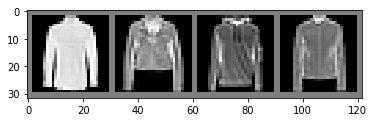

 frog  deer  bird  deer


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imagesFromBatches(iterator,quantity):
    dataiter = iter(iterator)
    images, labels = dataiter.next()    
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(quantity)))
    return (images,labels)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [45]:
import torch.nn as nn
# Importa funciones de convolución
import torch.nn.functional as F

from torchsummary import summary

# nn.Module: Clase base para todos los módulos de red neuronal. Sus modelos también deben subclasificar esta clase.
#### ESTA CREANDO UN OBJETO QUE SERA LA RED NEURONAL
class Net(nn.Module):
    #### Módulo de red neuronal?? - ¿ESTA CREANDO EL CONSTRUCTOR DEL OBJETO
    def __init__(self):
        super(Net, self).__init__()
        #### ESTAS SON FUNCIONES PRIVADAS DEL OBJETO
        
        # CONVOLUCION: Transformar la imagen para representar sus características relevantes y eliminar la información irrelevante
        # para resolver el problema de clasificación.
        
        # nn.Conv2d(in_channels, out_channels, kernel_size): Aplica una convolución 2D sobre una señal de entrada
        #                                                    compuesta de varios planos de entrada.
        #    in_channels: Número de canales en la imagen de entrada.
        #    out_channels: Número de canales producidos por la convolución. Número de filtros.
        ####    kernel_size: Tamaño del núcleo que está convolucionando. -- TAMAÑO DEL FILTRO EN ESTA CASO MATRIZ 5X5
        self.conv1 = nn.Conv2d(1, 6, 5)
        
        # POOLING: Reducir el tamaño de las imágenes, acelerar los tiempos de cálculo y mejorar la detección de las características
        # nn.MaxPool2d(kernel_size, stride=None): Aplica un max pooling 2D sobre una señal de entrada compuesta por varios planos de entrada.
        #            kernel_size: El tamaño de la ventana sobre la cual se tomara un máximo. El tamaño del filtro.
        #            stride: El paso de la ventana.
        self.pool = nn.MaxPool2d(2, 2)
        
        
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        #Fully-connected layers o MultiLayer Perceptron - Ultimas capas de la CNN o red neuronal convolucional
        # Algoritmo Perceptrón (Rosemblatt, 1962) resuelve problema de clasificación binaria.
        # nn.Linear(in_features, out_features): Aplica una transformación lineal a los datos entrantes: y = xA^T+b
        #         in_features: Tamaño de cada muestra de entrada.: metodos de clasficiacion
        #         out_features: Tamaño de cada muestra de salida.
        #         
        
        self.fc1 = nn.Linear(512, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

summary(net,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          61,560
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 75,146
Trainable params: 75,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.29
Estimated Total Size (MB): 0.33
----------------------------------------------------------------


In [46]:
# torch.optim: Es un paquete que implementa varios algoritmos de optimización.
import torch.optim as optim

criterion = nn.CrossEntropyLoss()#calcula quien tiene el menor "gradiente", cual punto alrededor es el minimo

# optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False): Implementa stochastic gradient descent 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#algoritmo para actualizar los parametros

In [47]:
for epoch in range(4):  # loop over the dataset multiple times
#itera y trata de encontrar las lmejores solucions para este sistema
#hacer el proceso varias veces, empezando desde un punto distinto
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

ValueError: Expected input batch_size (2) to match target batch_size (4).

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))